In [23]:
import re
from pprint import pprint

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import jieba
from sklearn.model_selection import train_test_split, cross_validate, cross_val_predict, KFold
from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    roc_curve,
    auc,
    precision_recall_curve,
    RocCurveDisplay
)
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.preprocessing import LabelBinarizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC


# 設定繪圖環境
plt.rcParams['font.family'] = 'Microsoft YaHei'
plt.rcParams['axes.unicode_minus'] = False
plt.style.use('ggplot')

In [19]:
# 讀取資料
df = pd.read_csv('chiikawa_unified_data.csv')

# 假設「artContent」是文章內容，「category」是標籤
df = df.rename(columns={'artContent': 'text', 'category': 'label'})

# 移除缺失值
df = df.dropna(subset=['text', 'label'])

# 定義斷詞函式
def tokenize(text):
    return [t for t in jieba.lcut(text) if len(t) > 1]

# 4. 拆訓練／測試集
X_train_raw, X_test_raw, y_train, y_test = train_test_split(
    df['text'],
    df['label'],
    test_size=0.2,
    random_state=42,
    stratify=df['label']
)

# 使用 TF-IDF 轉換文本為向量
vectorizer = TfidfVectorizer(tokenizer=tokenize, max_features=5000)
X_train = vectorizer.fit_transform(X_train_raw)
X_test = vectorizer.transform(X_test_raw)

In [25]:
# 初始化模型  
dt = DecisionTreeClassifier(max_depth=10, random_state=0)  
lr = LogisticRegression(max_iter=1000, random_state=0)  

# 訓練  
dt.fit(X_train, y_train)  
lr.fit(X_train, y_train)  

X_train_resampled, y_train_resampled = X_train, y_train

In [26]:
# 初始化各種模型
models = {
    '邏輯斯迴歸': LogisticRegression(max_iter=1000, class_weight='balanced', random_state=0),
    '多項式貝氏': MultinomialNB(),
    '決策樹': DecisionTreeClassifier(max_depth=10, class_weight='balanced', random_state=0),
    '隨機森林': RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=0),
    'SVM': svm.LinearSVC(class_weight='balanced', random_state=0)
}

# 訓練模型
for name, model in models.items():
    if name == '多項式貝氏':
        model.fit(X_train_resampled, y_train_resampled)
    else:
        model.fit(X_train_resampled, y_train_resampled)
print("模型訓練完成！")


模型訓練完成！


In [27]:
cv_results = {}
for name, model in models.items():
    # MultinomialNB 需用 dense array
    X = X_train_resampled.toarray() if name == '多項式貝氏' else X_train_resampled
    scores = cross_validate(
        model, X, y_train_resampled, cv=5,
        scoring=['accuracy', 'precision_macro', 'recall_macro'], return_train_score=False
    )
    cv_results[name] = {
        '準確率': np.mean(scores['test_accuracy']),
        '精確率': np.mean(scores['test_precision_macro']),
        '召回率': np.mean(scores['test_recall_macro'])
    }
print("5-fold 交叉驗證結果：")
for name, res in cv_results.items():
    print(f"  {name} → 準確率: {res['準確率']:.3f}，精確率: {res['精確率']:.3f}，召回率: {res['召回率']:.3f}")


d:\anaconda\envs\tf1_env\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\anaconda\envs\tf1_env\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\anaconda\envs\tf1_env\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\anaconda\envs\tf1_env\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedM

5-fold 交叉驗證結果：
  邏輯斯迴歸 → 準確率: 0.729，精確率: 0.797，召回率: 0.796
  多項式貝氏 → 準確率: 0.686，精確率: 0.593，召回率: 0.531
  決策樹 → 準確率: 0.616，精確率: 0.730，召回率: 0.699
  隨機森林 → 準確率: 0.802，精確率: 0.837，召回率: 0.814
  SVM → 準確率: 0.760，精確率: 0.809，召回率: 0.804



=== 邏輯斯迴歸 分類報告 ===
                precision    recall  f1-score   support

CAROUSEL_ALBUM      0.719     0.728     0.724       831
        C_CHAT      0.844     0.809     0.826        94
       HELPBUY      1.000     0.900     0.947        10
         IMAGE      0.729     0.714     0.721       658
         VIDEO      0.741     0.742     0.742       741
     gossiping      0.743     0.821     0.780        67

      accuracy                          0.735      2401
     macro avg      0.796     0.786     0.790      2401
  weighted avg      0.735     0.735     0.735      2401



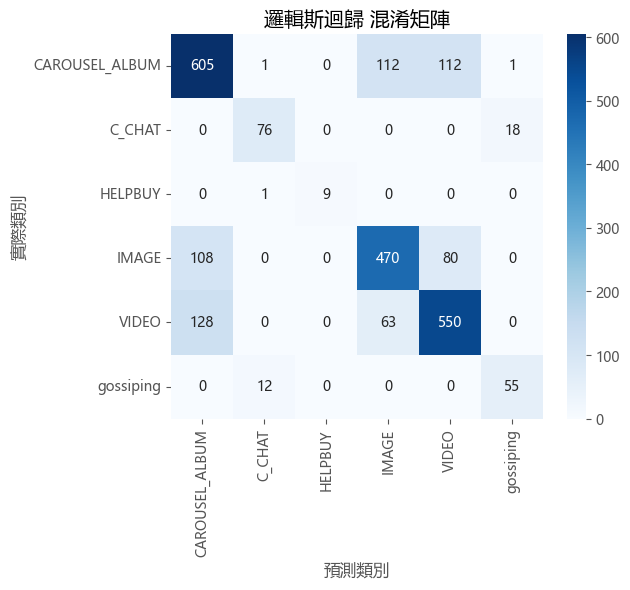


=== 多項式貝氏 分類報告 ===
                precision    recall  f1-score   support

CAROUSEL_ALBUM      0.630     0.771     0.694       831
        C_CHAT      0.581     0.989     0.732        94
       HELPBUY      0.000     0.000     0.000        10
         IMAGE      0.729     0.632     0.677       658
         VIDEO      0.740     0.637     0.685       741
     gossiping      1.000     0.224     0.366        67

      accuracy                          0.682      2401
     macro avg      0.613     0.542     0.526      2401
  weighted avg      0.697     0.682     0.676      2401



d:\anaconda\envs\tf1_env\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\anaconda\envs\tf1_env\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\anaconda\envs\tf1_env\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


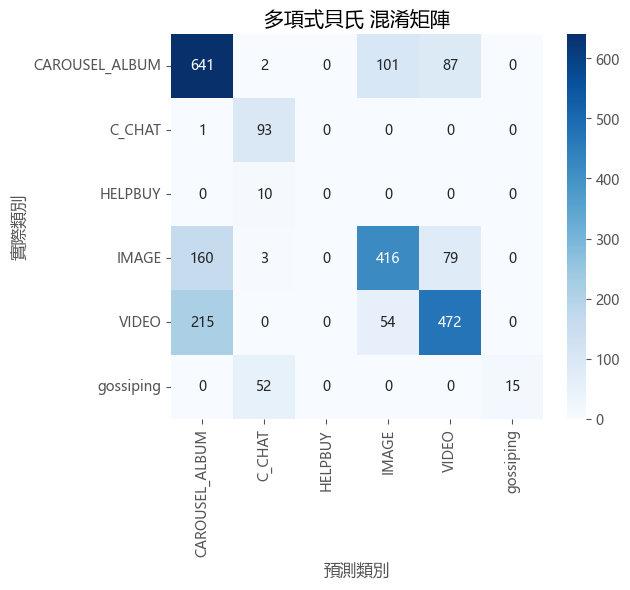


=== 決策樹 分類報告 ===
                precision    recall  f1-score   support

CAROUSEL_ALBUM      0.553     0.777     0.646       831
        C_CHAT      0.733     0.936     0.822        94
       HELPBUY      1.000     1.000     1.000        10
         IMAGE      0.747     0.552     0.635       658
         VIDEO      0.670     0.518     0.584       741
     gossiping      0.864     0.567     0.685        67

      accuracy                          0.637      2401
     macro avg      0.761     0.725     0.729      2401
  weighted avg      0.660     0.637     0.633      2401



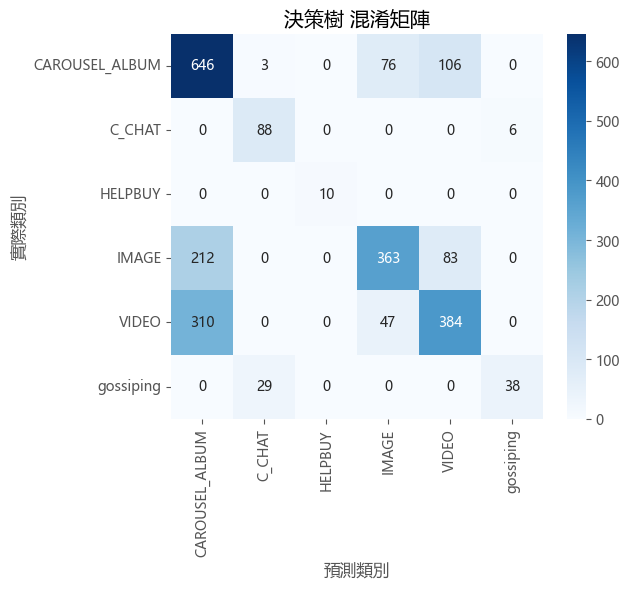


=== 隨機森林 分類報告 ===
                precision    recall  f1-score   support

CAROUSEL_ALBUM      0.817     0.827     0.822       831
        C_CHAT      0.794     0.904     0.846        94
       HELPBUY      1.000     0.900     0.947        10
         IMAGE      0.854     0.809     0.831       658
         VIDEO      0.789     0.815     0.802       741
     gossiping      0.836     0.687     0.754        67

      accuracy                          0.818      2401
     macro avg      0.848     0.824     0.834      2401
  weighted avg      0.819     0.818     0.818      2401



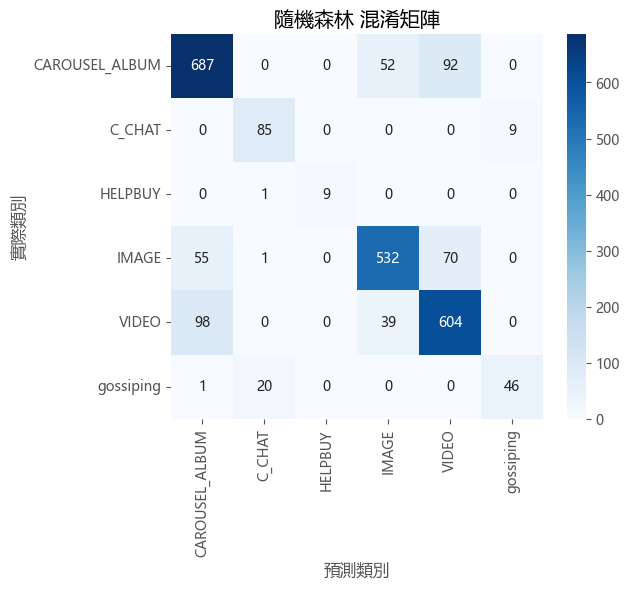


=== SVM 分類報告 ===
                precision    recall  f1-score   support

CAROUSEL_ALBUM      0.769     0.755     0.762       831
        C_CHAT      0.780     0.830     0.804        94
       HELPBUY      1.000     0.900     0.947        10
         IMAGE      0.762     0.778     0.770       658
         VIDEO      0.754     0.754     0.754       741
     gossiping      0.734     0.701     0.718        67

      accuracy                          0.763      2401
     macro avg      0.800     0.786     0.793      2401
  weighted avg      0.763     0.763     0.763      2401



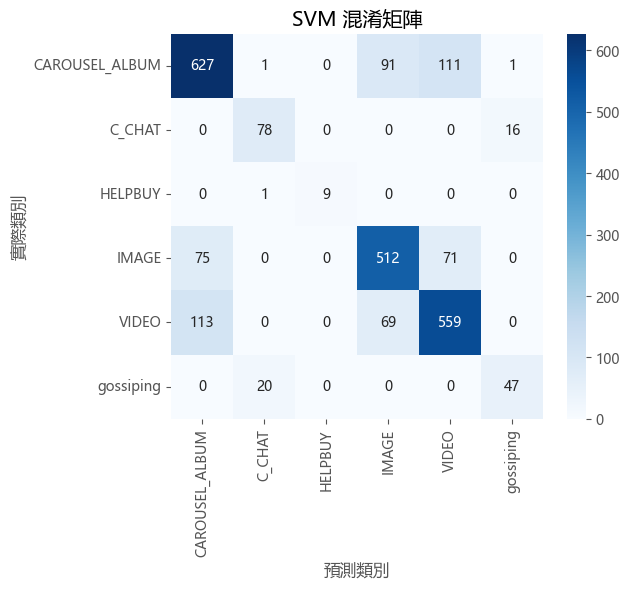

In [28]:
for name, model in models.items():
    # MultinomialNB 需用 dense array
    X_test_input = X_test.toarray() if name == '多項式貝氏' else X_test
    y_pred = model.predict(X_test_input)
    print(f"\n=== {name} 分類報告 ===")
    print(classification_report(y_test, y_pred, digits=3))
    cm = confusion_matrix(y_test, y_pred, labels=model.classes_ if hasattr(model, 'classes_') else np.unique(y_test))
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=np.unique(y_test), yticklabels=np.unique(y_test), cmap='Blues')
    plt.title(f"{name} 混淆矩陣")
    plt.ylabel("實際類別")
    plt.xlabel("預測類別")
    plt.show()


) missing from current font.\site-packages\sklearn\tree\_export.py:677: UserWarning: Glyph 13 (
  ann.update_bbox_position_size(renderer)
) missing from current font.\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 13 (
  fig.canvas.print_figure(bytes_io, **kw)


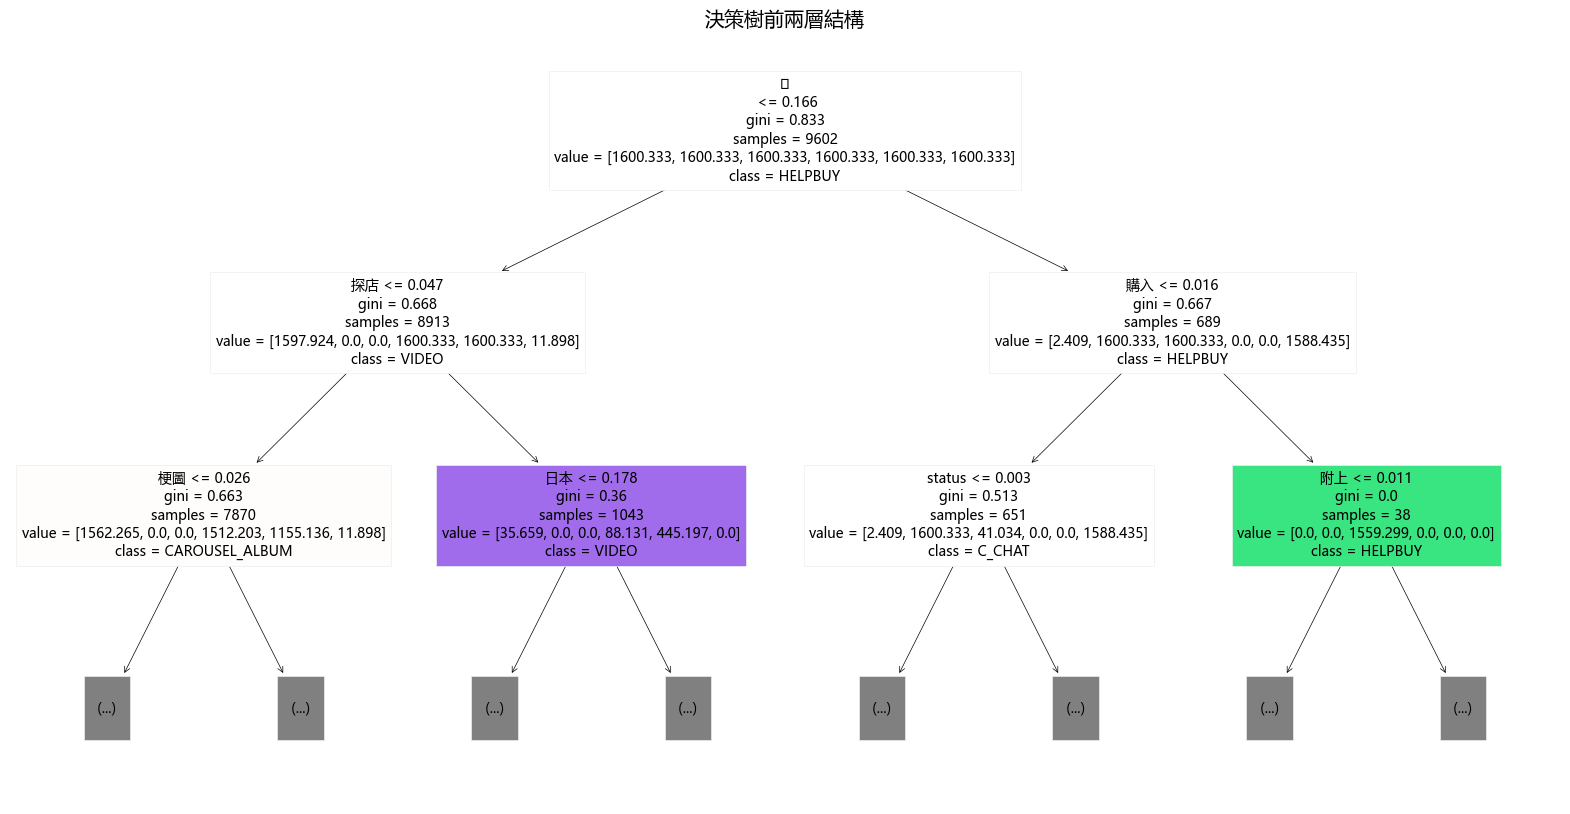

In [29]:
plt.figure(figsize=(20, 10))
plot_tree(
    models['決策樹'], max_depth=2,
    feature_names=vectorizer.get_feature_names_out(),
    class_names=models['決策樹'].classes_,
    filled=True, fontsize=10
)
plt.title("決策樹前兩層結構")
plt.show()
